## Summary Data for GraphML Files

In [1]:
import graph_tool.all as gt
import os
import re
import numpy as np
import graph_tool
import seaborn as sns
import matplotlib.pyplot as plt

from lib.analysis import clustering
from lib.analysis import centrality
from lib.analysis import dist
from lib.analysis import model
from lib.analysis import power
from lib.analysis import stats

## Part 1: Summary Statistics

Basic statistics for each country's government

In [2]:
data = 'data'
ignore = ['.DS_Store']
nets = {}

In [16]:
for country in [d for d in os.listdir(data) if d not in ignore]:
    path = os.path.join(data, country)
    if country not in nets:
        nets[country] = []
    for dir_ in [f for f in os.listdir(path) if f not in ignore]:
        if not dir_.endswith('.graphml'):
            net_path = os.path.join(path, dir_)
            for net in [f for f in os.listdir(net_path) if f not in ignore]:
                if net.endswith('.graphml'):
                    g = gt.load_graph(os.path.join(net_path, net))
                    g.set_directed(False)
                    gt.remove_parallel_edges(g)
                    gt.remove_self_loops(g)
                    nets[country].append((net[:-8], g))

In [17]:
for country, graphs in nets.items():
    with open(f'summary/summary.{country}.csv', 'w') as f:
        f.write(','.join(['Name', 'Number of Edges', 'Number of Vertices',
                  'Clustering Coefficient', 'Average Degree',
                  'Average Excess Degree', 'Average Distance',
                  'Size of LCC', 'Number of CC']) + '\n')
        for name, graph in graphs:
            f.write(f'{name},{str(stats.summary(graph))}\n')

## Part 2: Assortativity

Computes assortativity on specified attribute for every country across years 

In [3]:
individual_graphs = {}
root = 'data/'
countries = os.listdir(root)
nets = [country + "/" + net + "/" for country in countries
                            for net in os.listdir(root + country)
                            if not net.endswith('.graphml') and net != '.DS_Store']
for net in nets:
    country = re.search(r'^(\w+)/',net).group(1)
    for x in os.listdir(root+net):
        if x != '.DS_Store' and x.endswith('.graphml') and x != 'raw':
            individual_graphs[x] = (country, gt.load_graph(root + net + x))

In [7]:
attribute = 'party'
label = 'party_id'
with open("assortivity_summary.csv", "w+") as f:
    f.write(','.join(['Assortivity Measure']) + '\n')
    for name, (country, g) in individual_graphs.items():
        print(name)
        if attribute in g.vertex_properties:
            g.set_directed(False)
            gt.remove_parallel_edges(g)
            stats.generate_party_property(g, attribute)
            f.write(f'{name},{str(stats.assortativity_summary(g, label))}\n')

net_se2014-2018.graphml
net_se2010-2014.graphml
net_se2006-2010.graphml
net_se1998-2002.graphml
net_se2002-2006.graphml
net_se1988-1991.graphml
net_se1994-1998.graphml
net_se1991-1994.graphml
us.115.graphml
us.114.graphml
us.113.graphml
net_fr_an2007-2012.graphml
net_fr_an2002-2007.graphml
net_fr_an1988-1993.graphml
net_fr_an1986-1988.graphml
net_fr_an2012-2017.graphml
net_fr_an1997-2002.graphml
net_fr_se1997-2002.graphml
net_fr_se2012-2017.graphml
net_fr_se1986-1988.graphml
net_fr_se1988-1993.graphml
net_fr_se1993-1997.graphml
net_fr_se2002-2007.graphml
net_fr_se2007-2012.graphml
net_ch_cs1995-1999.graphml
net_ch_cs2003-2007.graphml
net_ch_cs2011-2015.graphml
net_ch_cs1999-2003.graphml
net_ch_cs2007-2011.graphml
net_ch_cn2003-2007.graphml
net_ch_cn1999-2003.graphml
net_ch_cn2007-2011.graphml
net_ch_cn2011-2015.graphml
net_ch_cn1995-1999.graphml
uk.graphml
net_dkEconomy.graphml
net_dkEnvironment.graphml
net_dkHousing.graphml
net_dkCulture.graphml
net_dkJustice.graphml
net_dkImmigration

In [8]:
for name, (country, g) in individual_graphs.items():
    name = name[:-8]
    if label in g.vertex_properties:
        gt.graph_draw(g, vertex_fill_color=g.vertex_properties['party_id'],
                      edge_color='#00000050', output=f'plots/graph/{country}/assortativity/assortativity_{name}.png')

## Part 3: Graphing Centrality

In [9]:
# # BETWEENNESS
# for name, (country, g) in individual_graphs.items():
#     name = name[:-8]
#     if label in g.vertex_properties:
#         vertex, edge = centrality.betweenness(g, scale=50)
#         gt.graph_draw(g, vertex_size=vertex, edge_pen_width=edge,
#                       edge_color=edge, output=f'plots/graph/{country}/betweenness/betweenness_{name}.pdf')

In [10]:
# BETWEENNESS Vertex
for name, (country, g) in individual_graphs.items():
    name = name[:-8]
    if label in g.vertex_properties:
        vertex, _ = centrality.betweenness(g, scale=100)
        vertex = g.new_vp('float', vertex.a + 5)
        threshold = vertex.a[np.argsort(vertex.a)[-int(g.num_vertices() * 0.03)]]
        top5p = vertex.a > threshold
        top5p = g.new_vp('boolean', top5p)
        gt.graph_draw(g, vertex_size=vertex, vertex_fill_color=top5p,#edge_pen_width=edge,
                      edge_color='#00000050', output=f'plots/graph/{country}/betweenness/betweenness_{name}.png')

In [11]:
# CLOSENESS
for name, (country, g) in individual_graphs.items():
    name = name[:-8]
    if label in g.vertex_properties:
        vertex = centrality.closeness(g, scale=20)
        gt.graph_draw(g, vertex_size=vertex, vertex_fill_color=vertex,
                      edge_pen_width=0.1, edge_color='#00000050',
                      output=f'plots/graph/{country}/closeness/closeness_{name}.png')

In [12]:
# EIGENVECTOR vertex_size=vector
for name, (country, g) in individual_graphs.items():
    name = name[:-8]
    if label in g.vertex_properties:
        value, vector = centrality.eigenvector(g, scale=70)
        gt.graph_draw(g, vertex_pen_width=1.4, vertex_fill_color=vector,
                      edge_color='#00000050', edge_pen_width=0.1,
                      output=f'plots/graph/{country}/eigenvector/eigenvector_{name}.png')

## Part 4: Distribution Analysis

/usr/local/Cellar/graph-tool/2.27_1/libexec/lib/python3.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


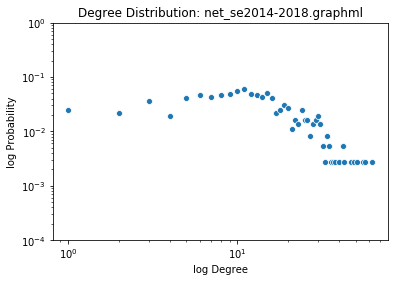

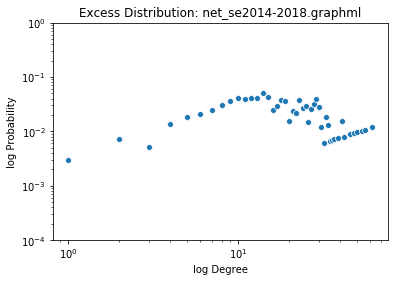

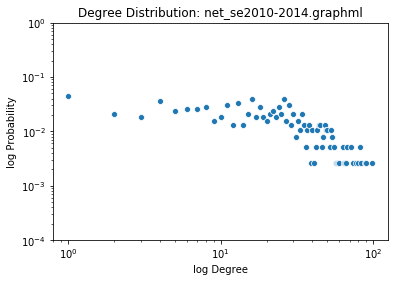

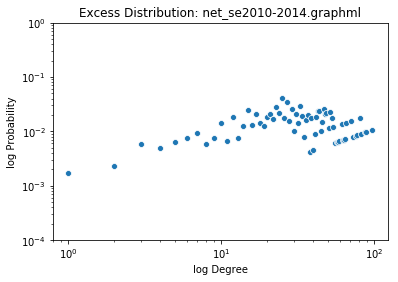

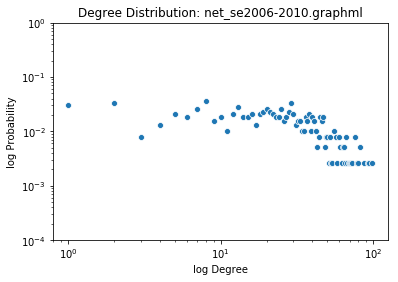

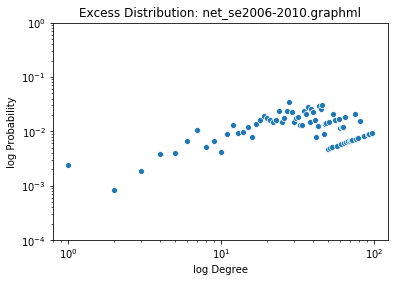

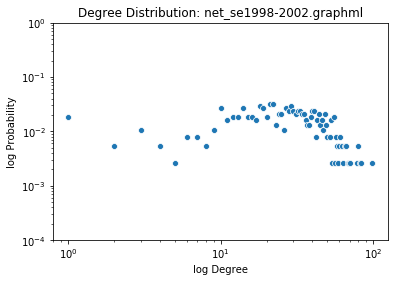

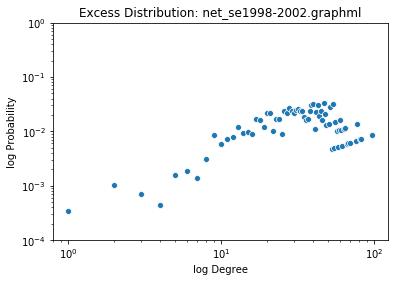

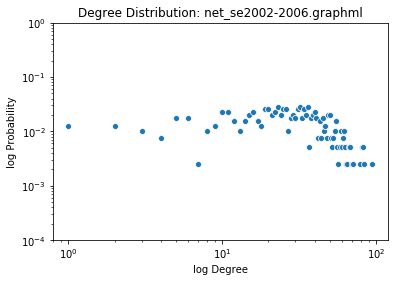

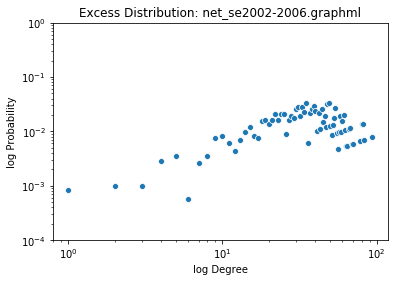

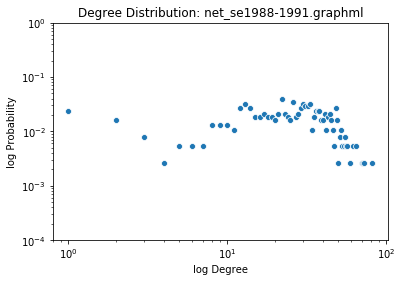

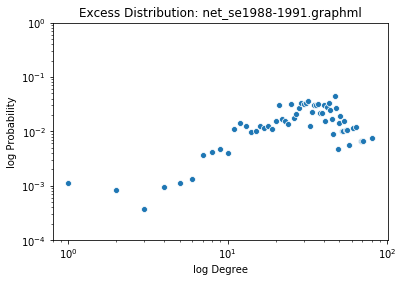

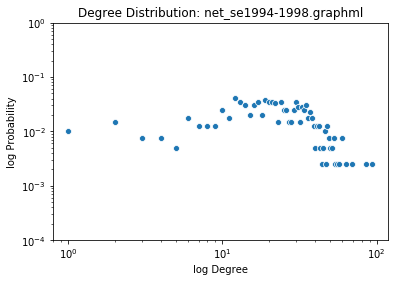

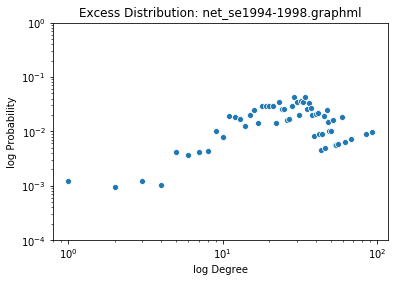

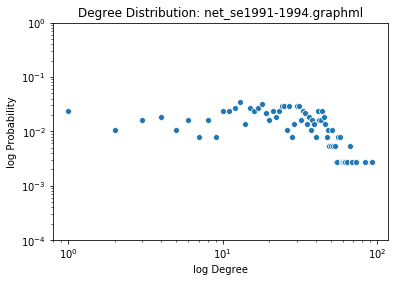

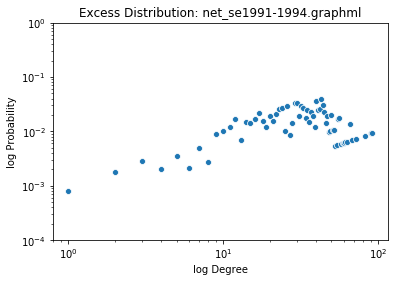

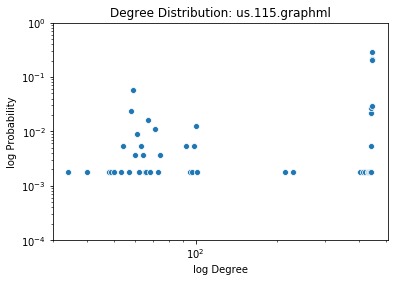

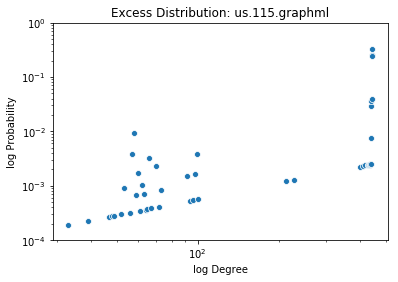

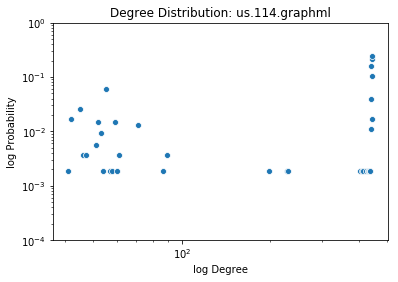

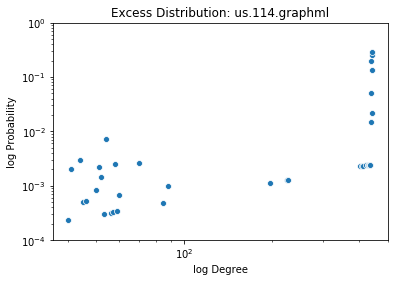

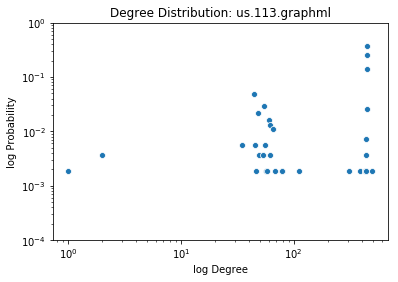

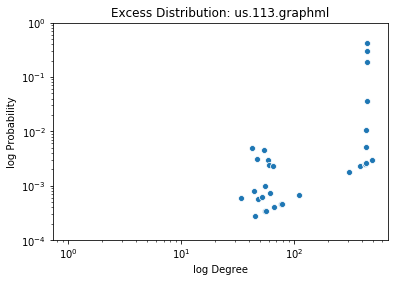

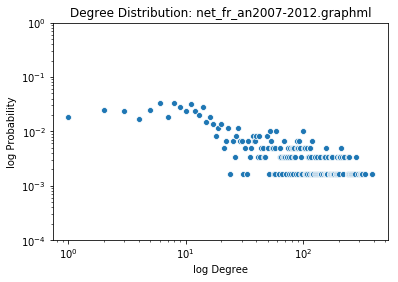

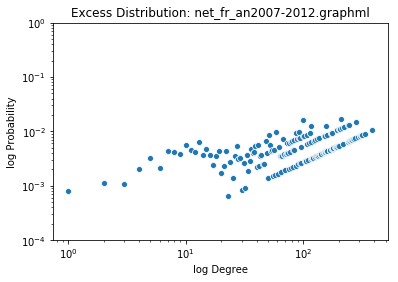

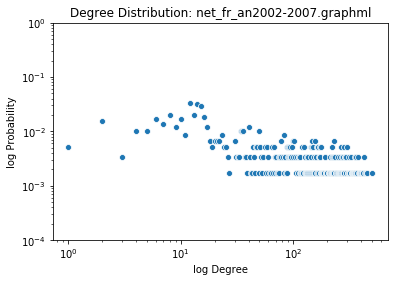

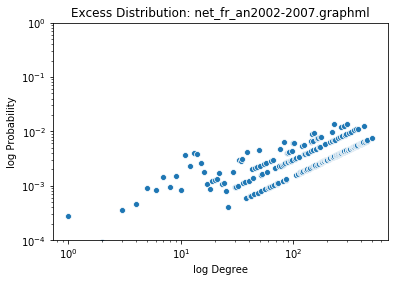

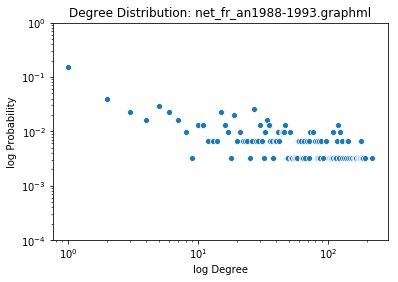

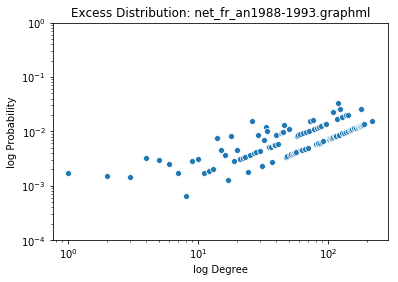

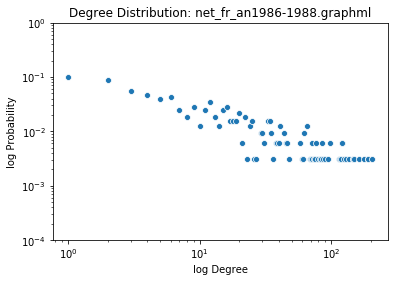

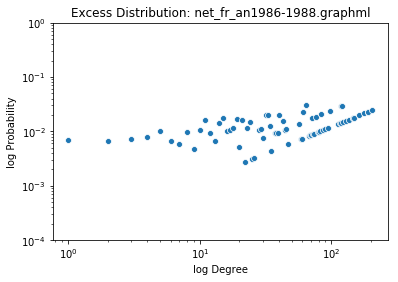

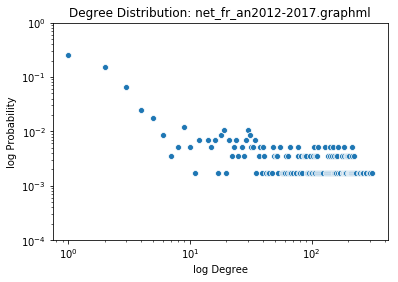

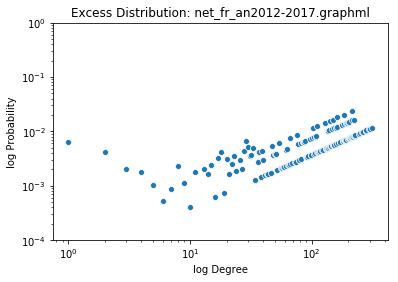

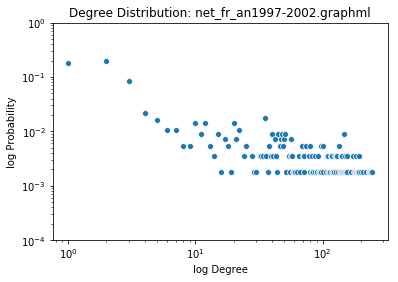

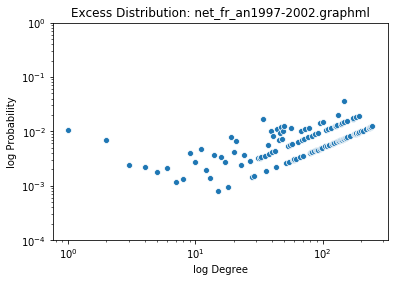

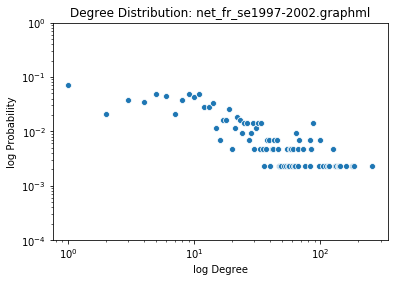

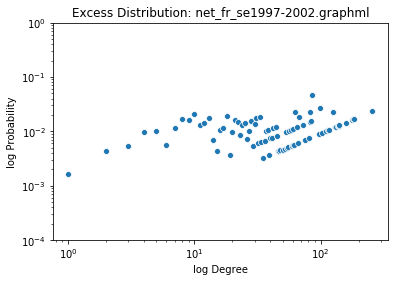

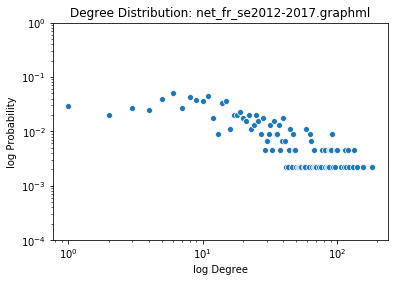

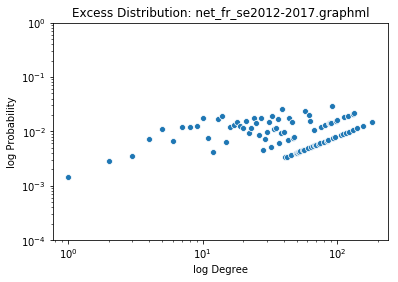

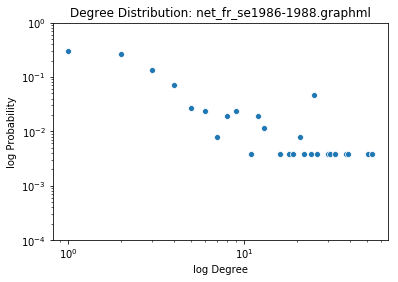

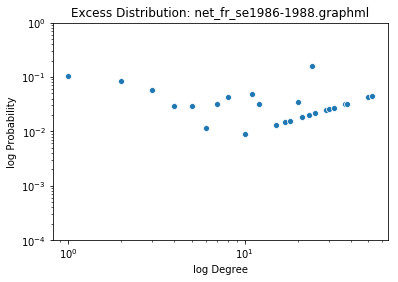

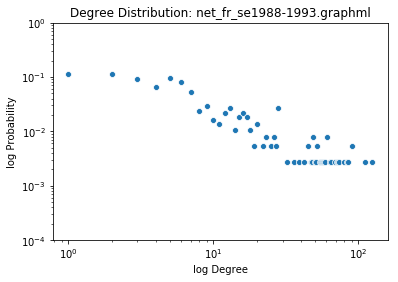

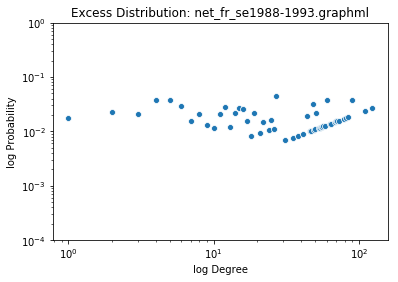

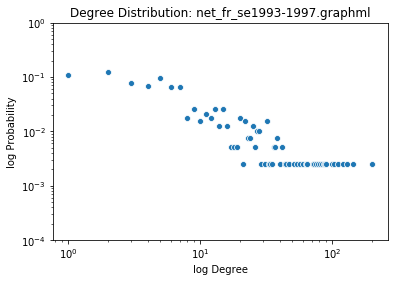

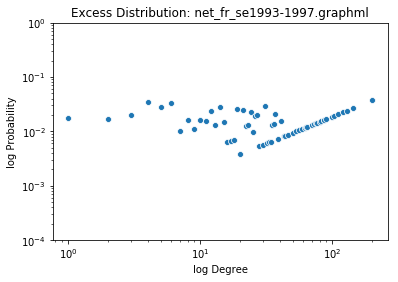

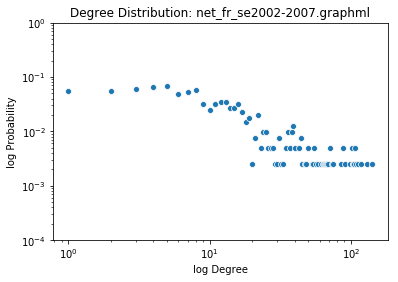

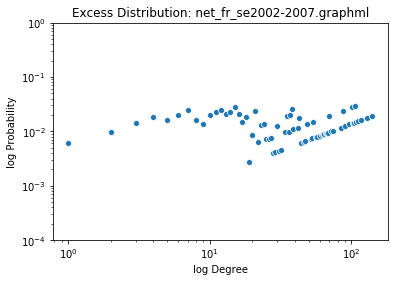

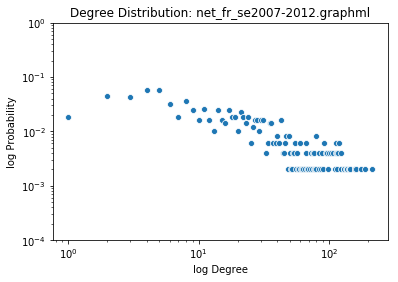

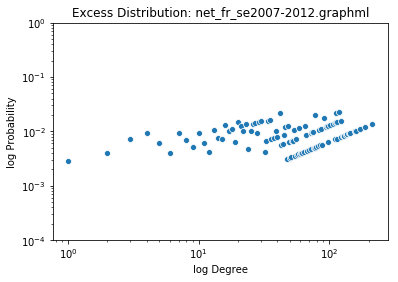

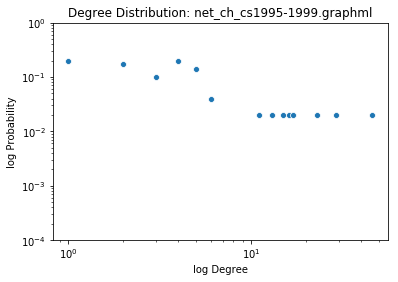

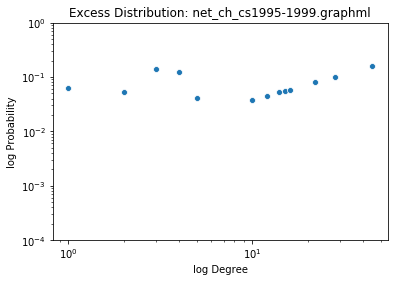

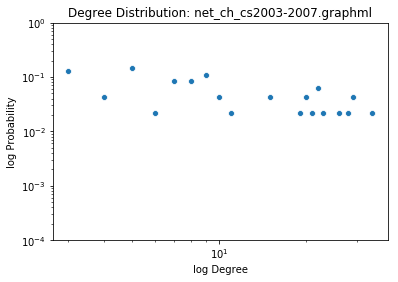

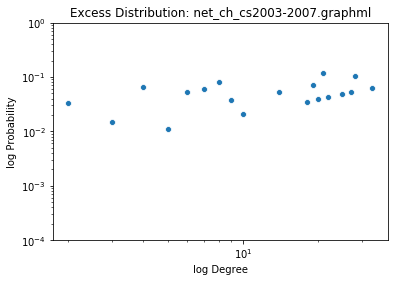

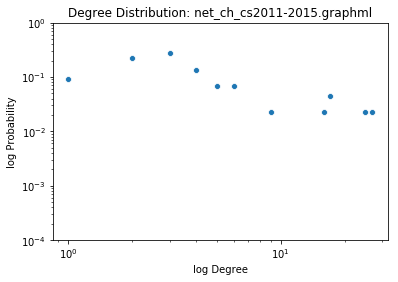

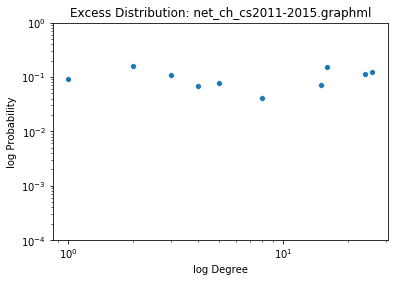

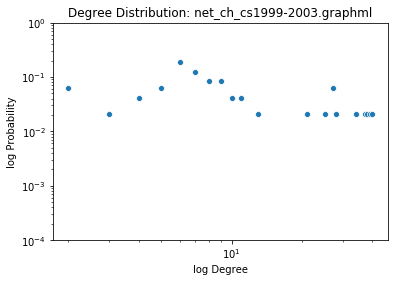

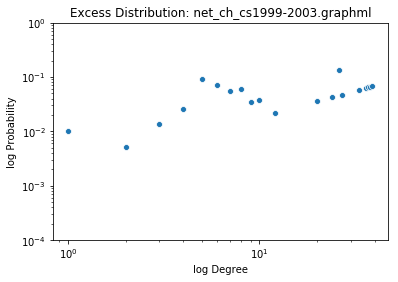

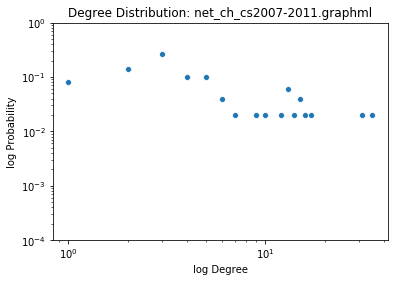

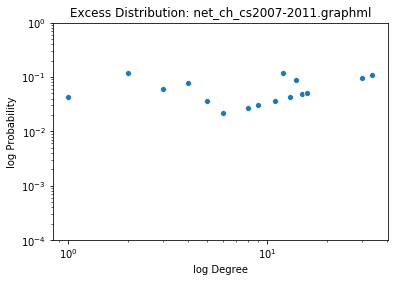

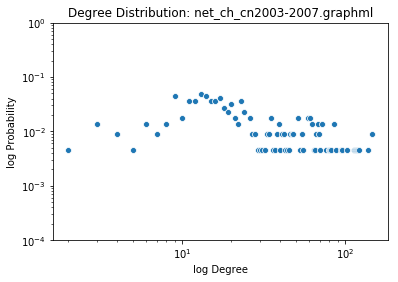

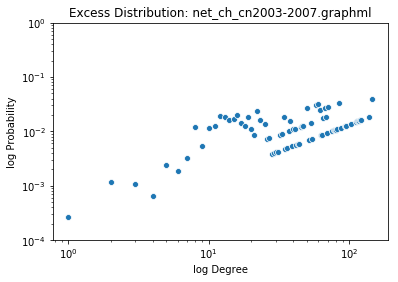

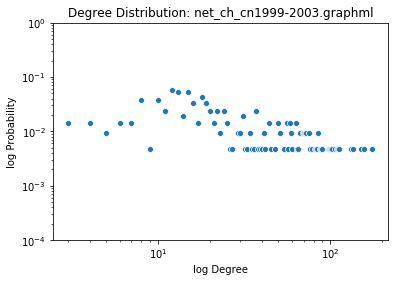

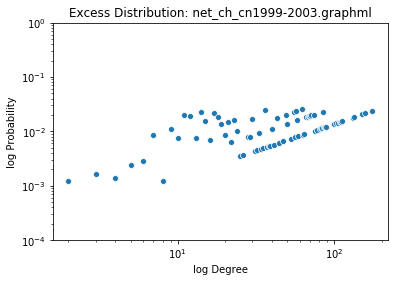

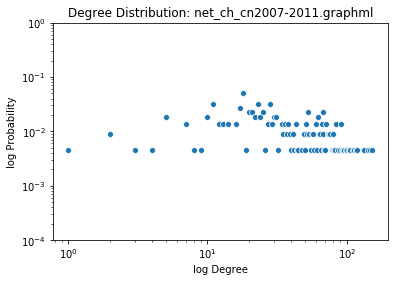

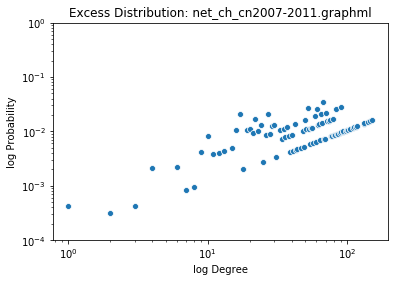

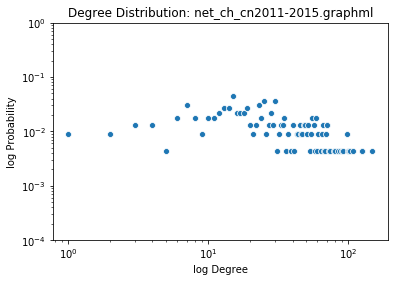

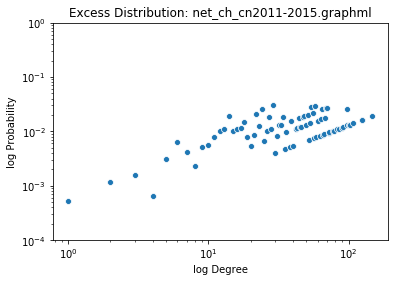

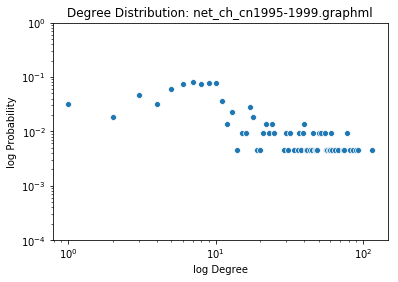

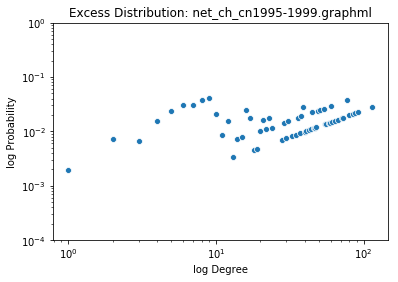

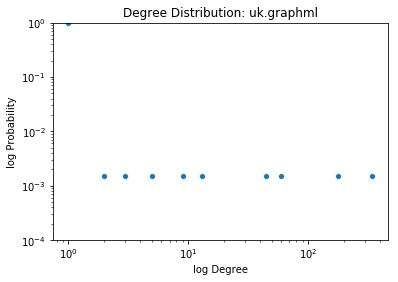

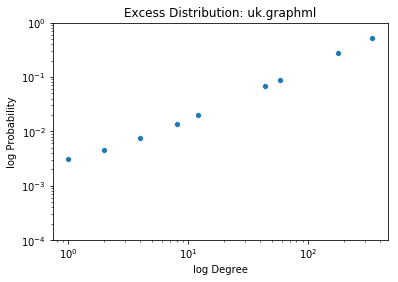

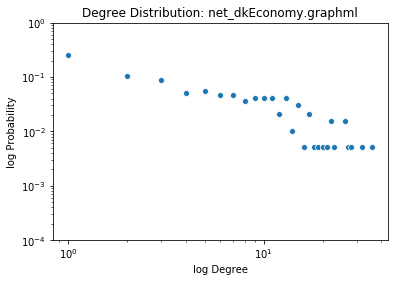

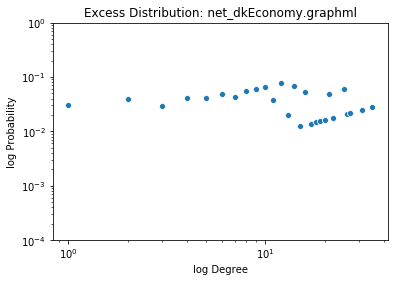

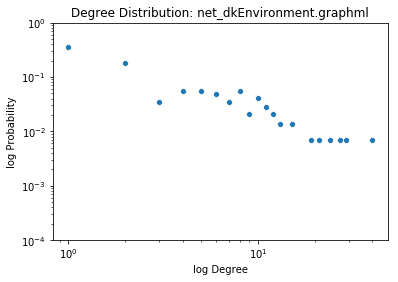

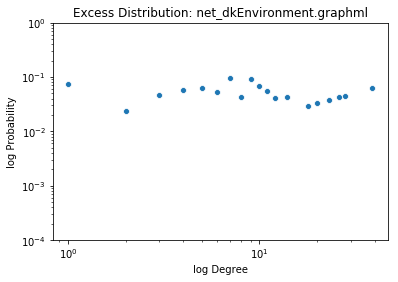

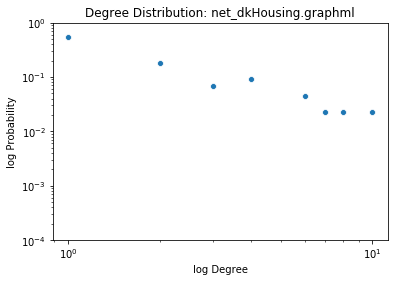

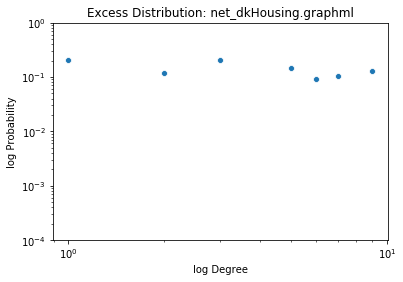

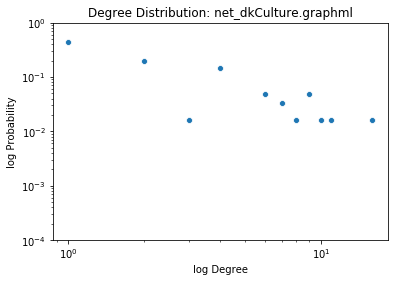

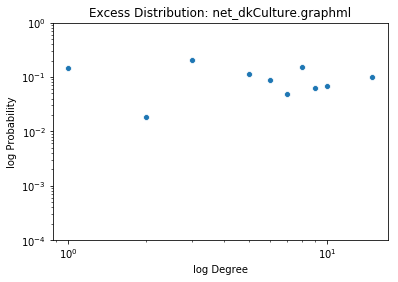

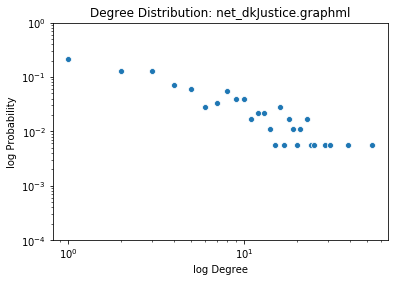

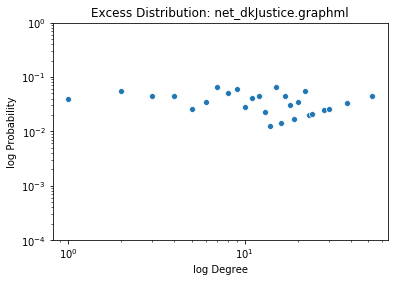

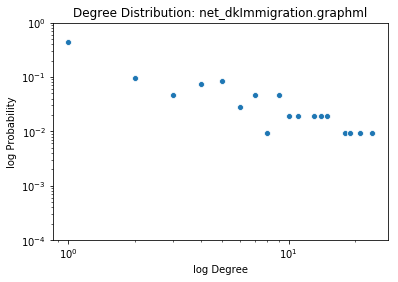

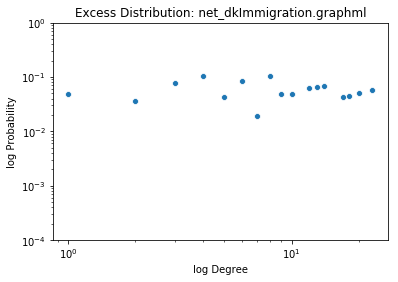

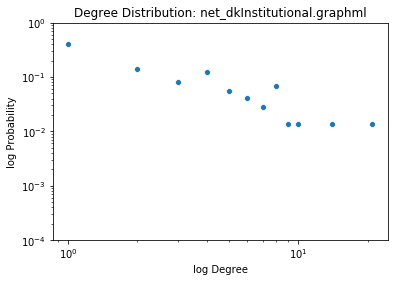

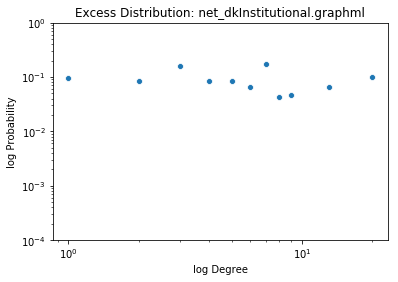

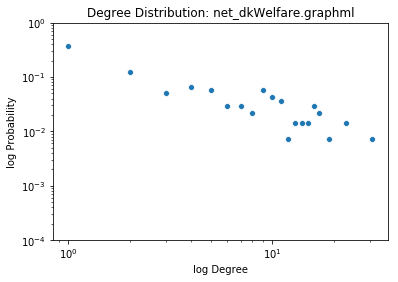

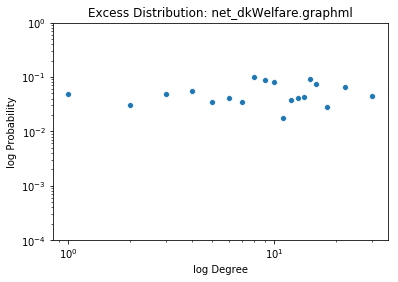

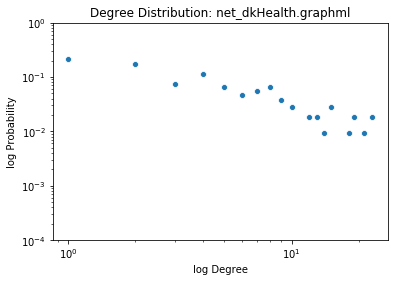

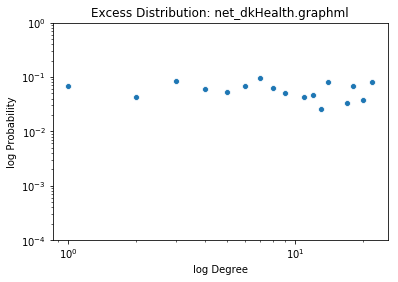

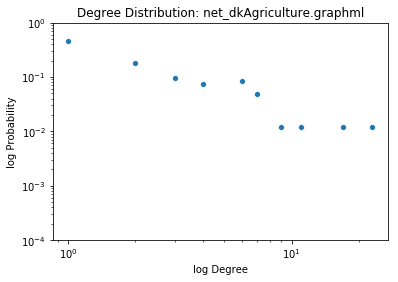

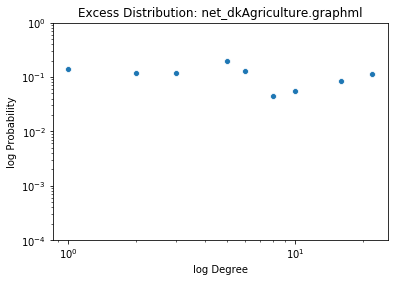

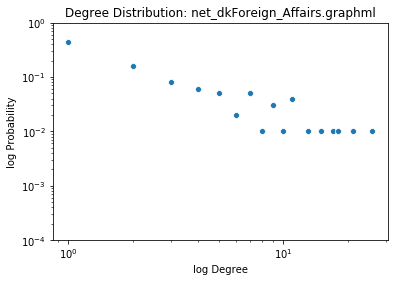

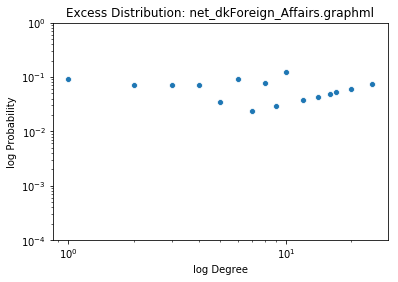

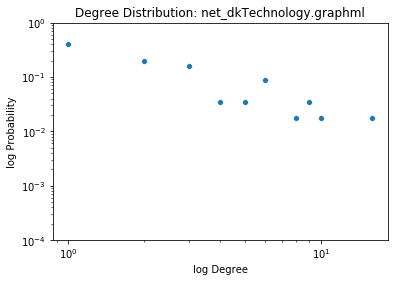

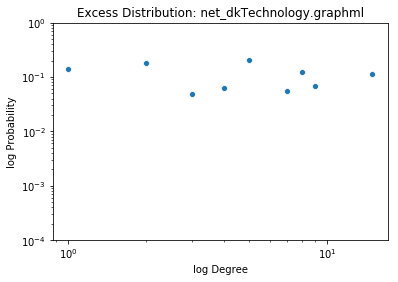

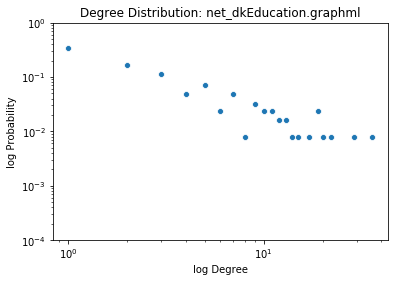

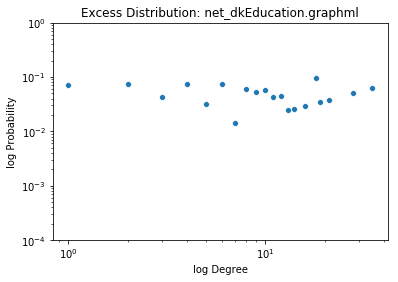

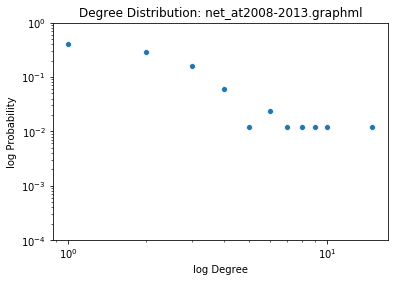

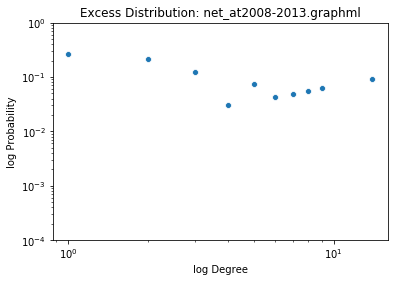

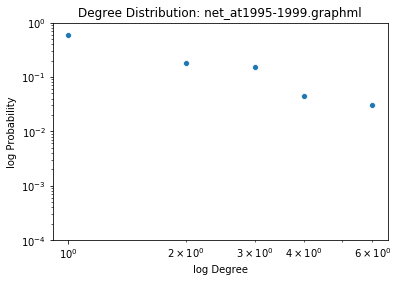

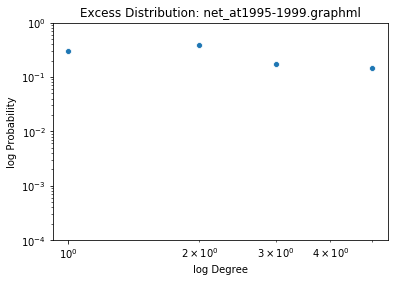

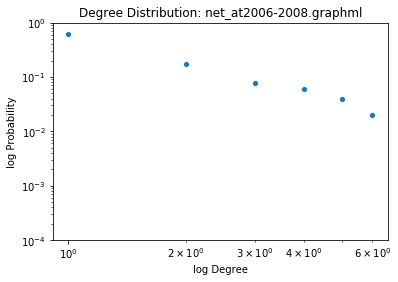

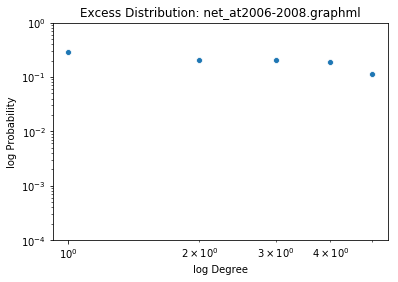

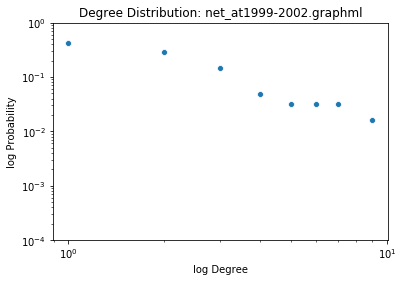

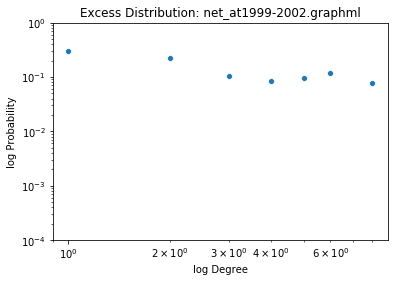

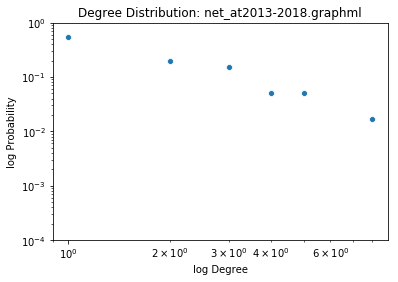

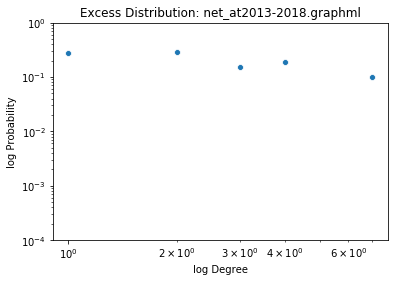

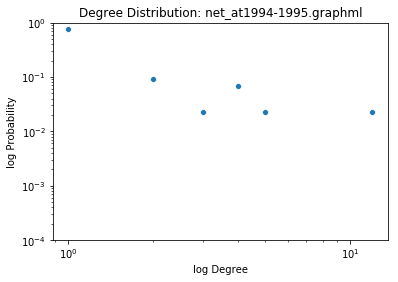

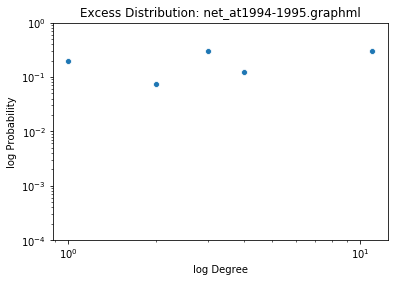

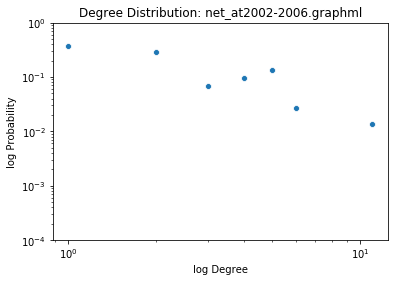

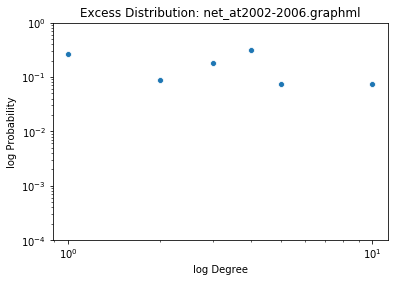

In [12]:
for name, (country, g) in individual_graphs.items():
    plt.figure()
    # plot degree distribution
    pdf, _ = dist.degree(g)
    k = np.arange(0, pdf.shape[0]) + 1
    sns.scatterplot(x=k[pdf > 0], y=pdf[pdf > 0])
    plt.title(f'Degree Distribution: {name}')
    plt.xlabel('log Degree'); plt.xscale('log')
    plt.ylabel('log Probability'); plt.yscale('log')
    plt.ylim(1e-4, 1)
    plt.savefig(f'plots/distributions/{country}/degree/degree_{name}.png')
    
    plt.figure()
    # plot excess degree distribution
    pdf, _ = dist.excess_degree(g)
    k = np.arange(0, pdf.shape[0]) + 1
    sns.scatterplot(x=k[pdf > 0], y=pdf[pdf > 0])
    plt.title(f'Excess Distribution: {name}')
    plt.xlabel('log Degree'); plt.xscale('log')
    plt.ylabel('log Probability'); plt.yscale('log')
    plt.ylim(1e-4, 1)
    plt.savefig(f'plots/distributions/{country}/excess/excess_{name}.png')